# Using 21cmFAST
For those that have 21cmFAST installed in their environment and would like to use it to analytically calculate the UV LFs and tau_e, we provide an example here comparing the analytic result to the emulated one.
## Import all needed packages

In [1]:
import numpy as np

from py21cmemu import Emulator, EmulatorInput
from py21cmemu.properties import FLAG_OPTIONS, COSMO_PARAMS, USER_PARAMS

import py21cmfast as p21

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from matplotlib import rcParams
import matplotlib.patches as mpatches
rcParams.update({'font.size': 30})

2023-05-15 17:16:39.657319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 17:16:39.901446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 17:16:39.902532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 17:16:40.789856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dani/anaconda3/envs/py10/lib/python3.10/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/dani/anaconda3/envs/py10/lib/python3.10/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out 

## Load data sample

In [2]:
test_sample = np.load('Test_data_sample.npz')
print(list(test_sample.keys()))

['X_test', 'parameters', 'limits', 'Ts', 'Tb', 'PS', 'tau', 'UVLFs', 'xHI']


## Load input parameters

In [3]:
test_params = test_sample['X_test']

## Load simulation outputs (i.e. 'true' outputs)

In [4]:
UVLFs_true = test_sample['UVLFs']
tau_true = test_sample['tau']

In [5]:
print('The shape of the output of the UV LFs is %d samples with %d redshift bins (z = 6, 7, 8, 10) and %d M_UV bins. ' % UVLFs_true.shape)

The shape of the output of the UV LFs is 100 samples with 4 redshift bins (z = 6, 7, 8, 10) and 31 M_UV bins. 


## Load emulator and get emulated summaries

In [6]:
emu = Emulator()
normed_input_params, output, output_errors = emu.predict(test_params, verbose = True)

2023-05-15 17:16:44.034806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-15 17:16:44.039140: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 114ms/step


In [7]:
UVLFs_emu = output['UVLFs']
tau_emu = output['tau']
xHI_emu = output['xHI']
zs = output['redshifts']
MUV_emu = output.Muv

In [8]:
list(output.keys())

['Tb', 'xHI', 'Ts', 'PS', 'tau', 'UVLFs']

## Convert units into 21cmFAST units and calculate UVLFs and tau analytically

In [9]:
emu_in = EmulatorInput()
astro_param_keys = emu_in.astro_param_keys
input_in_p21_units = emu_in.make_param_array(test_params, normed = False)

In [10]:
analytic_tau = np.zeros(len(test_params))
analytic_UVLFs = np.zeros((len(test_params),2,4,100)) # Shape is: Nsamples, [M_UV, LF], [z = 6,7,8,10], M_UV bins

In [11]:
for i in range(len(test_params)):
    analytic_tau[i] = p21.wrapper.compute_tau(
                    redshifts=zs,
                    global_xHI=xHI_emu[i, :],
                    cosmo_params=COSMO_PARAMS,
                    user_params=USER_PARAMS,
                    )
    astro_params_dict = dict()
    for j, k in enumerate(astro_param_keys):
        astro_params_dict[k] = input_in_p21_units[i,j]
    analytic_UVLFs[i, ...] = np.array(
        p21.wrapper.compute_luminosity_function(
            redshifts=[6,7,8,10],
            astro_params=astro_params_dict,
            cosmo_params=COSMO_PARAMS,
            user_params=USER_PARAMS,
            flag_options=FLAG_OPTIONS,
        )
    )[[0,2],:,:]
    if i == 0:
        print('Output from uvlfs calculation has shape: \n',
              '3 (magnitude, halo mass, LF) %d redshift bins, and %d absolute magnitude bins.' %analytic_UVLFs[i].shape[1:])

Output from uvlfs calculation has shape: 
 3 (magnitude, halo mass, LF) 4 redshift bins, and 100 absolute magnitude bins.


In [12]:
def plot_true_vs_emu(x_emu, y_emu,
                     x_true, y_true,
                     x_label,y_label, 
                     title = None, xlims = None, 
                     leg_loc = (0.5, 0.5),
                     N = 10, offset = 0,
                     cs = None):
    if cs is None:
        cs = ['k','lime','b', 'orange', 'cyan', 'magenta', 'grey', 'pink', 'darkred', 'coral']
    y_true_interp = np.zeros(y_emu.shape)
    for i in range(y_emu.shape[0]):
        y_true_interp[i] = interp1d(x_true[i], y_true[i], fill_value = 'extrapolate')(x_emu)
    y_diff = abs(y_true_interp - y_emu)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
    axs = axs.flatten()

    diff_err_z = np.nanpercentile(y_diff, [2.5, 16,50, 84, 97.5], axis = 0)
    if title is not None:
        axs[0].set_title(title)
    for i, c in zip(range(N), cs):
        if i == N-1:
            labels = ['21cmEMU', '21cmFAST']
        else:
            labels = [None, None]
        axs[0].plot(x_true[i + offset, :], y_true[i + offset, :], lw = 3, color = c, label = labels[1])
        axs[1].plot(x_emu, y_diff[i + offset, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
        axs[0].plot(x_emu, y_emu[i + offset, :], lw = 2, ls = '-.', color = c, label = labels[0])

    axs[0].legend(loc = leg_loc, frameon = False)#framealpha=0.3)
    axs[1].plot(x_emu, diff_err_z[2, :], ls = '--', lw = 3, color = 'k', label = r'Median')
    axs[1].fill_between(x_emu, diff_err_z[1, :], diff_err_z[3, :], color = 'k', alpha = 0.2, label = r'68% CI')
    axs[1].fill_between(x_emu, diff_err_z[0, :], diff_err_z[4, :], color = 'k', alpha = 0.1, label = r'95% CI')

    handles = [mpatches.Patch(color='k', label='68% CI', alpha = 0.3),
              mpatches.Patch(color='k', label='95% CI', alpha = 0.1),
              ]
    plt.legend(handles=handles, loc = (0.2,0.5), frameon = False)
    axs[0].set_ylabel(y_label)
    axs[1].set_ylabel(r'Abs Diff')
    axs[1].set_xlabel(x_label)
    if xlims is not None:
        plt.xlim(xlims[0], xlims[1])
    plt.tight_layout()
    plt.show()

## Plot Analytic 21cmFAST vs 21cmEMU (UVLFs)

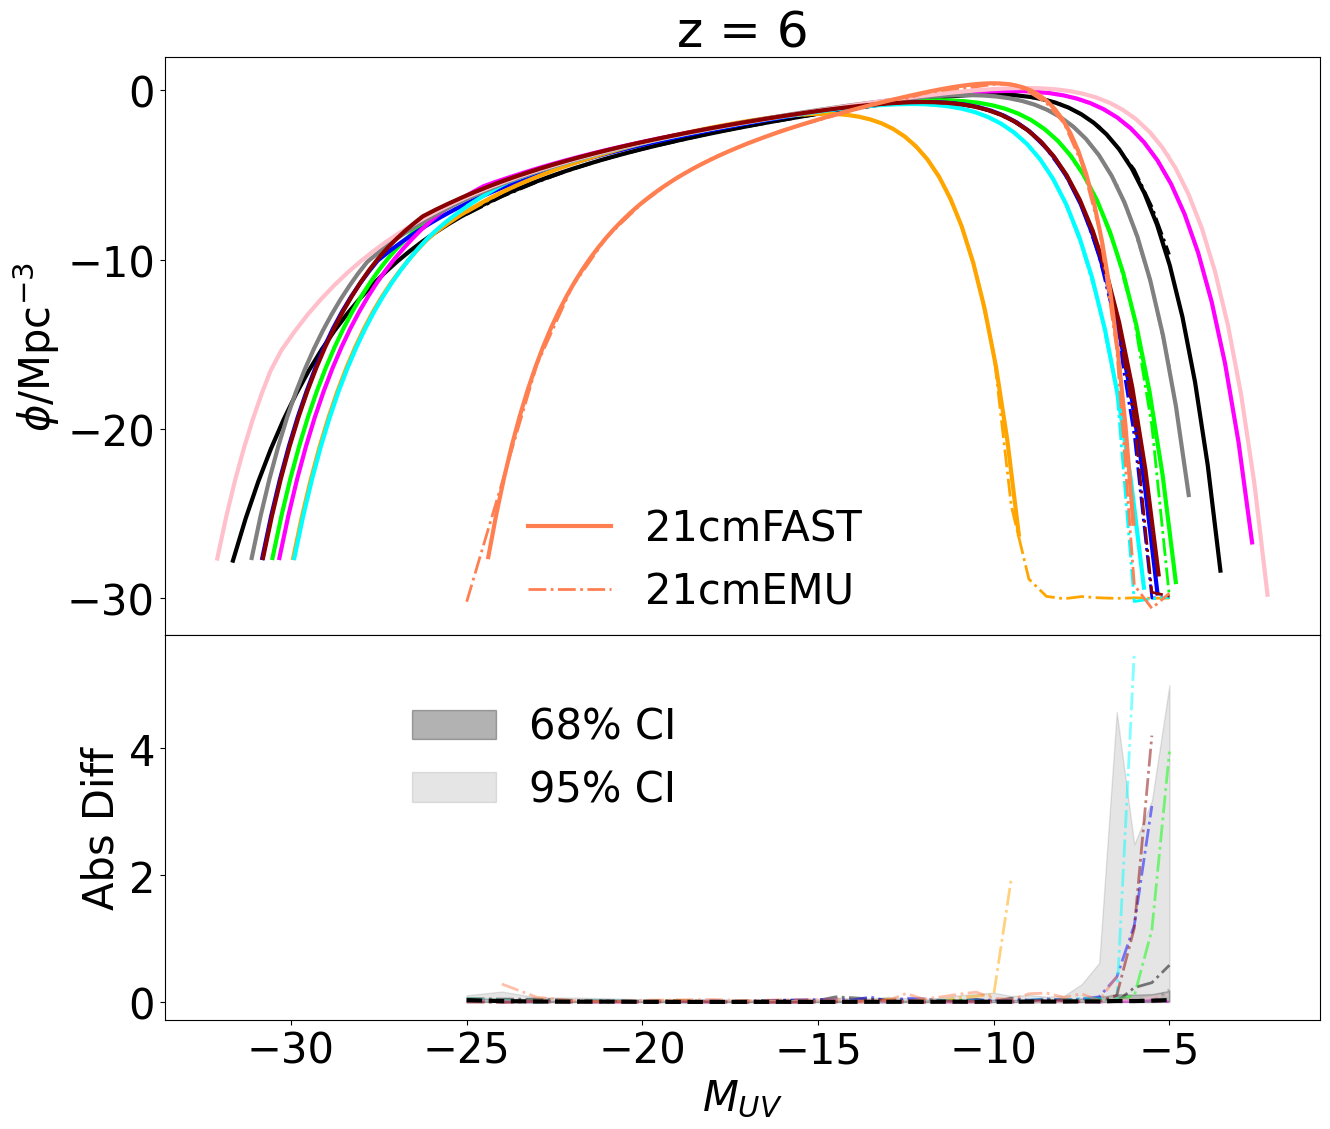

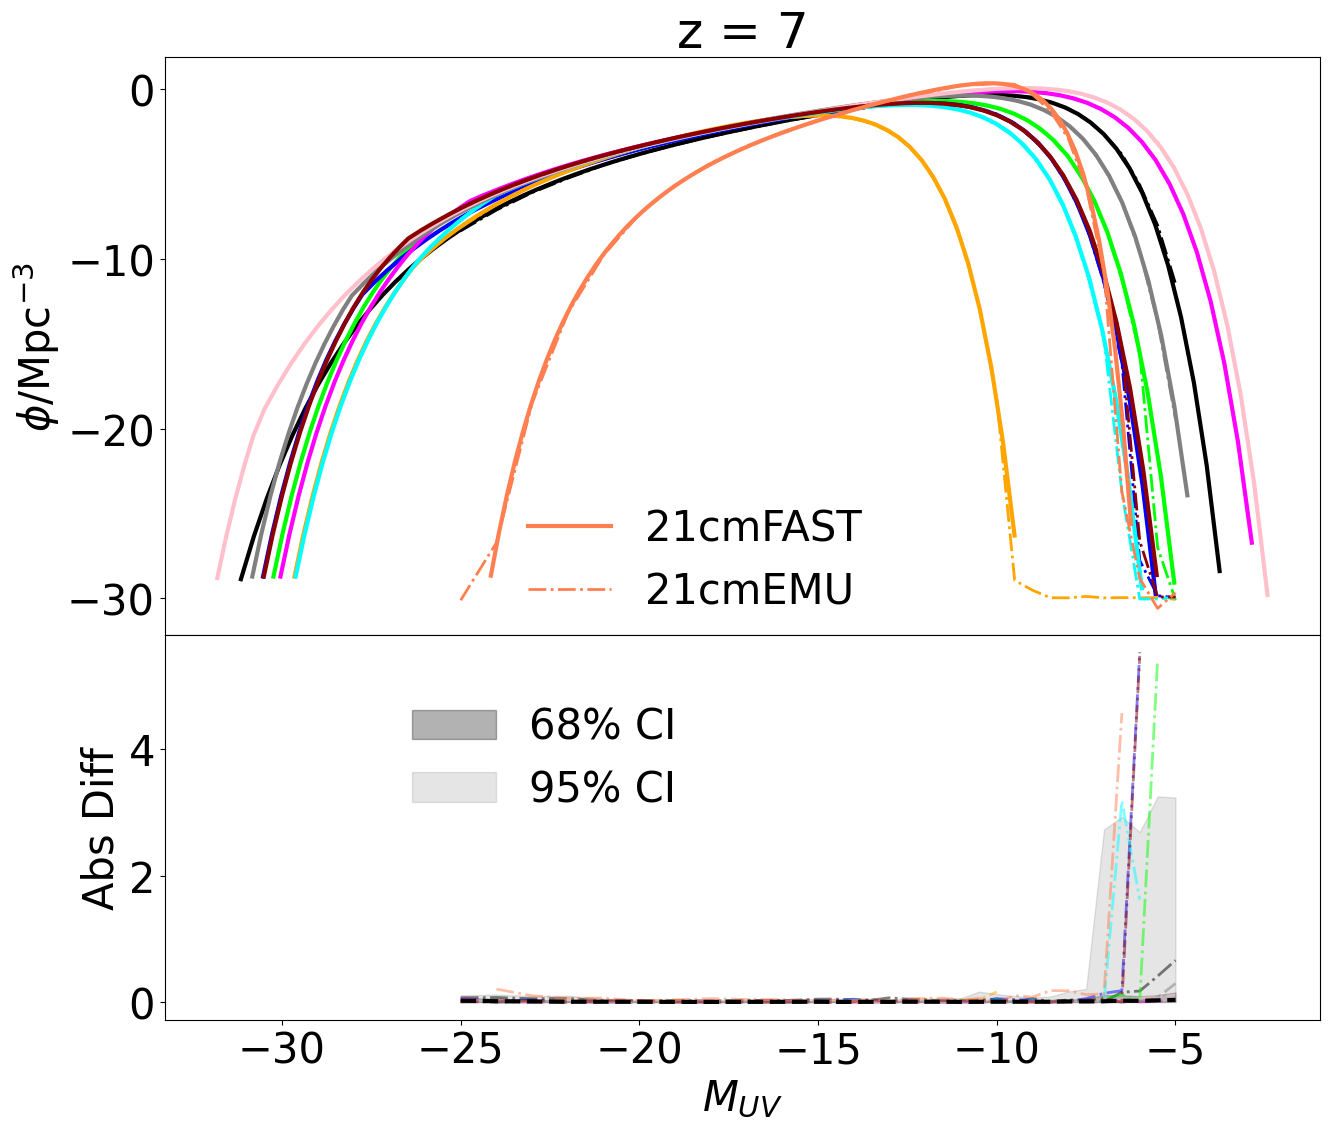

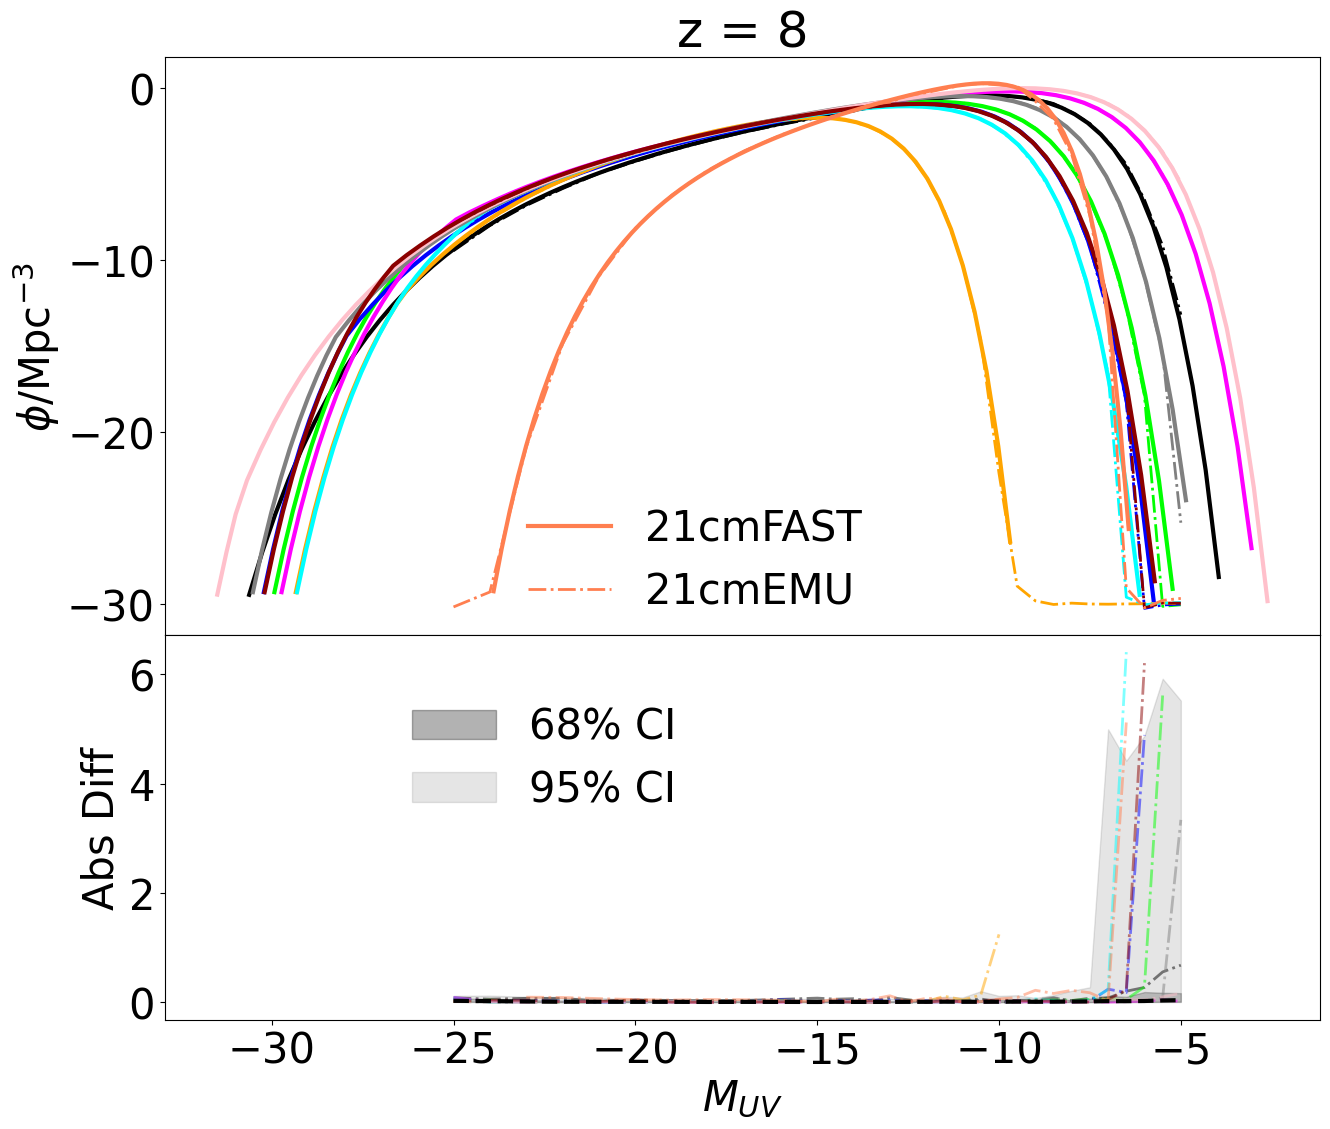

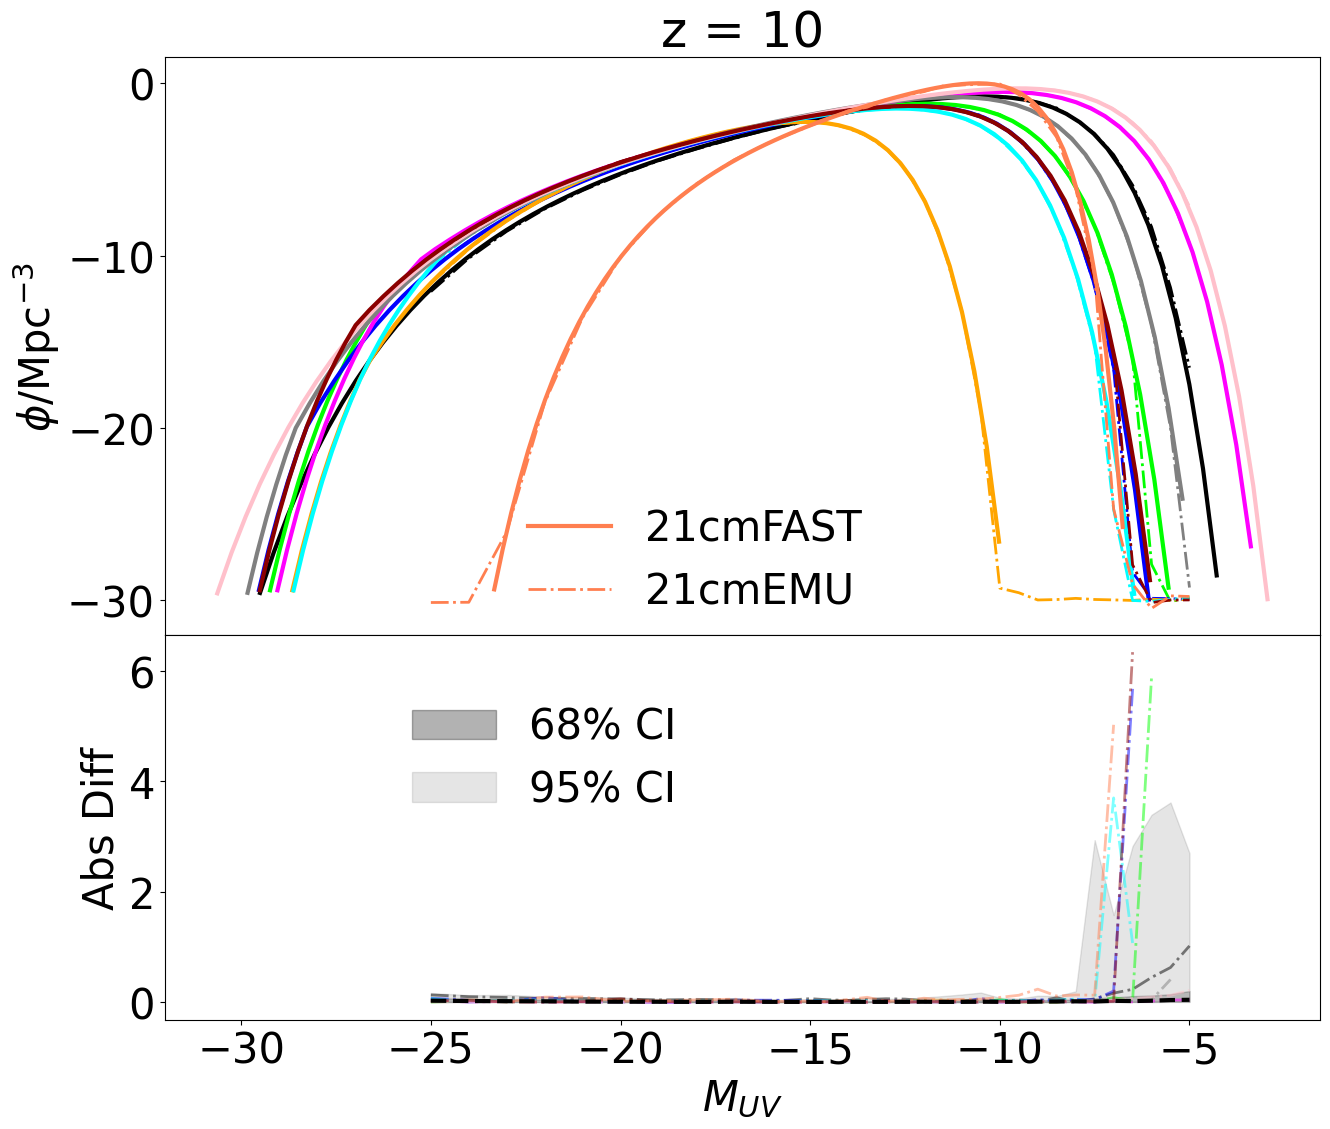

In [13]:
for z_bin in range(4):
    plot_true_vs_emu(MUV_emu, np.log10(UVLFs_emu[:,z_bin,:]),
                     analytic_UVLFs[:,0,z_bin,:] , analytic_UVLFs[:,1,z_bin,:],
                     r'$M_{UV}$', 
                     r'$\phi$/Mpc$^{-3}$',
                     leg_loc = (0.3,0.01),
                     title = 'z = %d'%output.UVLF_redshifts[z_bin],
                    )

## Plot 21cmFAST vs 21cmEMU (tau)

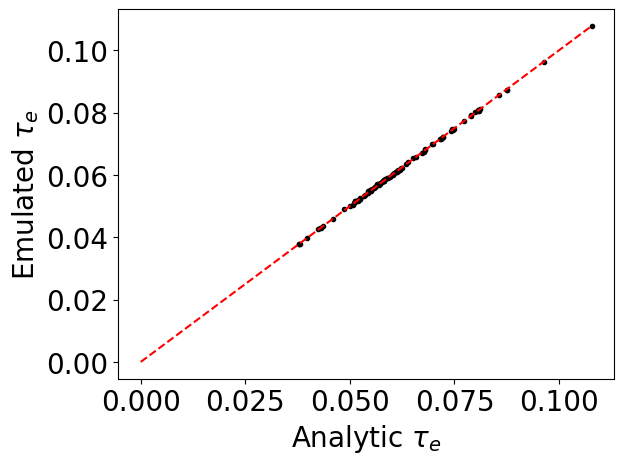

In [14]:
rcParams.update({'font.size': 20})
plt.scatter(analytic_tau, tau_emu, marker = '.', color = 'k')
line = np.linspace(0,max(analytic_tau), 10)
plt.plot(line, line, color = 'r', ls = '--')
plt.xlabel(r'Analytic $\tau_e$')
plt.ylabel(r'Emulated $\tau_e$')
plt.show()